# Belgium trains are always late

Belgium trains are always late. That might sounds like a cliché but this is unfortunately confirmed almost every day, especially in Brussels. Usually, I take the train at 8:06 heading to Ostend from Brussels South Station. I stop in beautiful Ghent where my office is located. I generally show up about 2 min before the scheduled departure time. With no exageration, I can say that my train is systematically delayed by about $8 \pm 5$ min. And it is now freaking cold here in Brussels. So I wait everyday in the Belgium blizzard, fulminating against the Belgium railway company, with the only consolation of reading the very "deep" articles from Metronews newspaper.

There is a second train stopping in Ghent, scheduled at 8:22 with destination Bruges. I take it from time to time, when I snooze my alarm so much
that I end up being late. Unfortunately this train isn't really more on time than the one leaving at 8:06. 
While I can not do much against trains delays, I might take advantage from the fact that two trains are leaving in a row; and try to determine at what time I should arrive at the station such as to wait the least before stepping in a train.

That's the main goal of this post.


## Modelisation of the train departure time

Departure times varies from day to day, so it is quite natural to use a probability distribution to describe this quantity. Idealy, I should use the train delay record of the Belgium railway company in order to define the shape of the distribution. This dataset is not publicly available, I therefore need to make some hypothesis on the distribution based on my own experience. 

### Shape of the distribution


It is quite common in the litterature to model phenomena such as departure time of metros with an exponential distribution, which is continuously decreasing on $\mathbb{R}^+$. I think it is not relevant in my situation as, from my experience, the most likely delay is about 8 min. Furthermore, the probabiliy that the train leaves before the scheduled time should be zero.

Let's call A the random variable "departure time of the train to Ostend" and $p_A(t)$ its distribution. 
    Given the discussion above, the simplest choice is the truncated normal distribution:

$$ p_A(t) = \frac{1}{1-F_A(C_A)} \frac{1}{\sigma_A \sqrt{2\pi} }  \text{exp}(- \frac{(t-\mu_A)^2}{2\sigma_A^2}) \ \  \text{for} \ \
t > C_A,$$

and $p_A(t) = 0 \ \ \text{otherwise}$.

$C_A$ is the theoretical departure time and $F_A( t )$ is the cumulative normal distribution with parameters $(\mu_A,\sigma_A$). 

I assume that the random variable $B$ "departure time of the train to Bruges", is independent from A, and also follows the same type of distribution. 

For the numerical implementation in Python, I rescale all quantities such that $C_A=0$ and I use the minute as the unit of time. The numerical values for the parameters are:
- train to Ostend scheduled at 8:06 (train A) : $\mu_A=8$, $\sigma_A=5$ and $C_A=0$,
- train to Bruges scheduled at 8:22 (train B) : $\mu_B=8$, $\sigma_B=5$ and $C_B=16$ .


### How to build truncated normal distribution in python?

In [46]:
#---------
# Create distribution for train A and B
#---------

import numpy as np
from scipy.stats import truncnorm
%matplotlib inline


# time variable in minutes, I need to take tMax quite large 
# to be sure that the numerical integration of the distribution is close to 1.0
t=np.arange(-10,1000,0.01)



The scipy.stats package contains an implementation of truncated normal distribution. We need to be cautious when using trucnom.pdf() as it requires first to rescale the cutoffs.

In [47]:

## parameters for train A
CminA=0. # theoretical depature time, acts as a cutoff for the distribution
CmaxA=10**4 # upper cutoff, not use, set to smth very large so that F(CmaxA)=1.
muA=8. 
sigA=5. 
CminA, CmaxA = (CminA - muA) / sigA, (CmaxA - muA) / sigA # rescale the cutoffs as required by truncom.pdf()

# parameters for train B
CminB=16.
CmaxB=10**4
muB=CminB+muA
sigB=sigA 
CminB, CmaxB = (CminB - muB) / sigB, (CmaxB - muB) / sigB


#build the distributions
pdfA=truncnorm.pdf(t,CminA,CmaxA,loc=muA,scale=sigA)
pdfB=truncnorm.pdf(t,CminB,CmaxB,loc=muB,scale=sigB)


Let's check what the distributions look like!

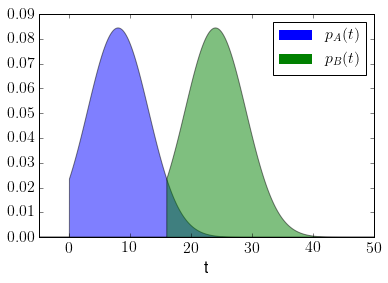

In [48]:
#----------------
# plot the distributions
#----------------

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# make fonts larger for plotting
fSize=16
mpl.rcParams['xtick.labelsize'] = fSize 
mpl.rcParams['ytick.labelsize'] = fSize 
mpl.rcParams['axes.labelsize'] = fSize
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'sans-serif')


plt.plot([], [], color='blue', linewidth=10)
plt.plot([], [], color='green', linewidth=10)
plt.legend(['$p_A(t)$','$p_B(t)$'],fontsize=fSize)
plt.fill_between(t,0,pdfA,facecolor='blue',alpha='0.5')
plt.fill_between(t,0,pdfB,facecolor='green',alpha='0.5')
plt.xlabel('t')
plt.xlim([-5,50]);



From the figure above, the implementation seems ok. As expected, $p_A(t)$ peaks at $t=8$ min and the cutoff occurs at $t=0$ min.
There is a non-negligible time interval starting at $t=16$ min where the distributions overlap. In practice, this means that train B might leave earlier than train A!

## The mean waiting time

Remember that the final goal is to determine at what time I shall arrive at the station so as to minimize the mean waiting time. Obviously, there is a very important ingredient still missing in the model: me!

### Here I am!

Computing the mean waiting time is greatly simplified by building a probalistic tree to determine which train leaves first. As any mean quantity, it involves some probability distributions. The tricky point is that I will modify these distributions through the time I show up at the station. 

Let's call G the variable "arrival time of Greghor at the station". Contrary to variables $A$ and $B$, $G$ is not random as I decide at what time I want to arrive at the station. 


### The probability tree


Once at the station, I will take the first departure to Ghent. I may face three distinct situations depending 
on the values of $G$:
1. $A > G $ and train A leaves first, I wait in average $\Delta A$
2. $A > G $ but train B leaves first, I wait in average $\Delta B$
3. $ A \le G $, train A is already gone when I arrive so I shall take train B, and wait in average $\Delta B$

Let's summarize the three situations on a probability tree

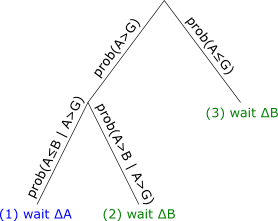

In [49]:
from IPython.display import Image
Image(filename='primitive/probaTree.png')

We can express the total mean waiting time by adding the contribution of each branch of the tree: 
$$ \Delta = [\text{prob}(A > G) \times \text{prob}(A \le B\ |\ A > G) ] \Delta A + 
[\text{prob}(A\le G)+ \text{prob}(A > G) \times \text{prob}(A > B \ |\  A > G) ] \Delta B  $$

#### Probability that I arrive after the departure of the train to Ostend

Just remains to compute the different terms in the previous equation. Let's start with the probaility to miss train A, $\text{prob}(A\le G)$, which is easy to get
$$ \text{prob}(A \le G) = \int_{-\infty}^G p_A(t) dt. $$

The probability to be on time for train A $\text{prob}(A > G)$ is also easily obtained as the sum of probability at the same "level" of the tree is 1, thus 
$\text{prob}(A > G) = 1- \text{prob}(A \le G)$.

The code below illustrates the computation of $ \text{prob}(A \le G)$ for $G=5$ min.

0.364555649783


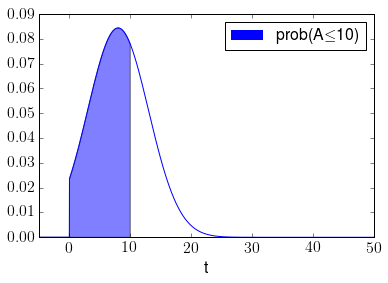

In [50]:

# illustrate pA(t>10)


plt.plot([], [], color='blue', linewidth=10)
plt.legend(['prob(A$\le$10)'],fontsize=fSize)

id=np.where(t <= 10.)
plt.fill_between(t[id],0,pdfA[id],facecolor='blue',alpha='0.5')
plt.hold
plt.plot(t,pdfA)
plt.xlim([-5,50]);
plt.xlabel('t')

# compute pA(t>10) from the cdf function
p=1-truncnorm.cdf(10,CminA,CmaxA,loc=muA,scale=sigA)
print p

The shaded area in the figure above represents the probability $\text{prob}(A > G)$ for G=10 min and is estimated about 0.36.
Note that I didn't represent the distribution for train B here as it doesn't play any role in this computation.

#### Probability that I catch the train to Ostend


Computing the probability that I take train A is more tricky. It implies that train A leaves before train B given that I arrive before the departure of train A,i.e. \text{prob}(A \le B\ |\ A > G).

This probability can be formally expressed by convolving $p_{Z+A| A > G}(t)$ and $p_{B | A > G}(t)$ where $Z=A-B$ is new random variable. I decide to renounce to mathematical rigor here and to choose a more intuitive approach consisting in evaluating $\text{prob}(A \le B\ |\ A > G) $ numerically.

The event $G > A$ does not modify the distribution of B since I will never show up at the station after the scheduled departure time of train B. Consequently, $p_{B | G > A}(t)=p_B(t)$.
Things are different with train A. My arrival time doesn't change the shape of $p_A(t)$ but simply acts a new cutoff so as to ensure that: $$ \int_G^{+\infty} p_{A|A > G} (t) dt =1$$

The numerical evaluation of $\text{prob}(A \le B\ |\ A > G)$, or equivalently $\text{prob}(A -B \le 0\ |\ A > G)$,  is obtained in three steps:
- draw a large number N of samples $a$ and $b$ from $p_{A| A > G}(t)$ and $p_B(t)$, respectively. 
- construct $z=a-b$ and count the number of times $n$ where $z \le 0$
- evaluate $\text{prob}(A \le B\ |\ A > G) \sim n/N$






The code below evaluates $\text{prob}(A \le B\ |\ A > G)$ for $G=14$ min and shows the histogram of $z=a-b$

0.95903


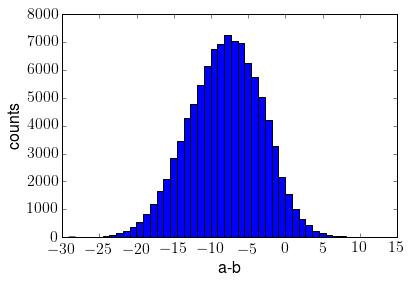

In [51]:
#  Draw nbSamp from the truncated normal distribution

nbSamp=10.**5
nBins=np.ceil(nbSamp**(1./3.))

cutoff= (14 - muA)/sigA

a=truncnorm.rvs(cutoff,CmaxA,loc=muA,scale=sigA,size=nbSamp)
b=truncnorm.rvs(CminB,CmaxB,loc=muB,scale=sigB,size=nbSamp)

z=a-b

# plot histogram
plt.hist(z,bins=nBins);
plt.xlabel('a-b')
plt.ylabel('counts')

# find where z <= 0
count=np.count_nonzero( z <= 0.)
print np.float(count)/nbSamp


Interestingly the distribution of $z=a-b$ is close to be normal even though $a$ and $b$ follow truncated normal distributions. If train A has more than 14 min delayed, there is still $96\%$ chances that train A will leave before train B. 

### How much do I wait if I take train A? If I take train B?

The average waiting time for train A and B are
$$\Delta A (G) = \int_{-\infty}^{+\infty} (t-G) p_{A|A> G} (t) dt$$

and

$$\Delta B (G) = \int_{-\infty}^{+\infty} (t-G) p_B (t) dt,$$

respectively.

### Numerical evaluation of the mean waiting time

In [52]:
# my arrival time
G=np.arange(-2,14,0.1)

#Prealloc

prob_AaftB=np.zeros(len(G)) # prob(A>B | A > G )
prob_AbfrB=np.zeros(len(G)) # prob(A<=B | A > G ))

prob_AbfrG=np.zeros(len(G)) # prob(A<= G)
prob_AaftG=np.zeros(len(G)) # prob(A > G)

wtA=np.zeros(len(G))  # \Delta A
wtB=np.zeros(len(G))  # \Delta B

waiting=np.zeros(len(G))  # total average waiting time

for gi in range(len(G)):
    
    #p( A <= G): train A is gone when I arrive
    prob_AbfrG[gi] = truncnorm.cdf(G[gi],CminA,CmaxA,loc=muA,scale=sigA)
    
    #p(tA>= G): train A is here when I arrive
    prob_AaftG[gi] = 1 - prob_AbfrG[gi]
    
    # distribution of (A| A > G)
    cutoff= (G[gi] - muA)/sigA     #rescale cutoff
    pdfAgG=truncnorm.pdf(t,cutoff,CmaxA,loc=muA,scale=sigA)
    
    # compute probability that A leaves before B given the value of G
    #evaluate prob(A - B <= 0 | A > G )
    nbSamp=10.**5
    a=truncnorm.rvs(cutoff,CmaxA,loc=muA,scale=sigA,size=nbSamp)
    b=truncnorm.rvs(CminB,CmaxB,loc=muB,scale=sigB,size=nbSamp)
    


    count=np.count_nonzero(a-b <= 0.)
    prob_AbfrB[gi]=np.float(count)/nbSamp #prob(A<=B | A > G ))
    prob_AaftB[gi]=1-prob_AbfrB[gi] #prob(A>B | A > G )
    
    #waiting time for train A
    wtA[gi]=np.trapz(pdfAgG*(t-G[gi]),t) 
    
    #waiting time for train B
    wtB[gi]=np.trapz(pdfB*(t-G[gi]),t)
    
    # mean waitinh time
    waiting[gi]=prob_AaftG[gi]*(prob_AbfrB[gi]*wtA[gi] + prob_AaftB[gi]*wtB[gi]) + prob_AbfrG[gi]*wtB[gi]
    
    
prob_A=prob_AaftG*prob_AbfrB #prob that I take train A
prob_B=(prob_AaftG*prob_AaftB+prob_AbfrG) #prob that I trake train B


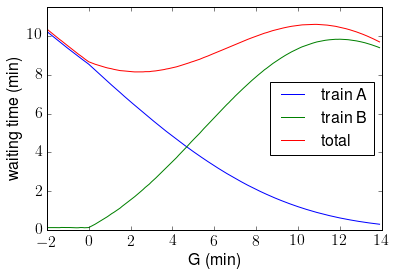

In [53]:
# plot the total mean waiting time and each contribution
%matplotlib inline
plt.plot(G,prob_A*wtA,G,prob_B*wtB,G,prob_A*wtA+prob_B*wtB)
plt.legend(['train A','train B','total'],loc=5,fontsize=fSize)
plt.ylabel('waiting time (min)')
plt.ylim([0.,11.5])
plt.xlabel('G (min)')

The chart above depicts the total waiting time (red curve) as well as the weighted contributions
from train A (blue curve) and train B (red curve).  
We can broadly distinguish three regions:
- $G\lesssim2.5$, the waiting time decreases with $G$ since the dominant contribution comes from train A. 
- $2.5 < G \lesssim 10.8$, even though the waiting time associated to train B decreases with G, the contribution from train B increases because the probability that I take train B increases. The contribution from train A does not longer compensate the contribution of train B resulting in an overall increase of the total waiting time. 
- $ G > 10.8 $, the contribution of train A becomes negligible. The total waiting asymptotically follows $\Delta B$,
the waiting time associated to train B, and therefore decreases with G.

According to this model, I should show up at the station around $G\sim 2.5$ min to minimize the waiting time. 
Nevertheless, it doesn't change much if I arrive right before the scheduled departure time of train A ($\Delta \sim 8.6$ min for $G=0$ min) or up to $4.5$ min afterwards ($\Delta \sim 8.5$ min for $G=4.5$ min). Unfortunately, maths show that I am condemned to wait at least about $8$ min. Damn it!

Before closing this post, I should mention that these findings strongly depend on the distribution that I have initially choosen. I will try to negogiate with the SNCB railway company and see if I can access the official train delays data. I am really keen on checking if the truncated normal distribution correctly describes the real data. Stay tuned! Updates are coming soon!